In [2]:
!pip install praat-parselmouth librosa soundfile scikit-learn joblib flask pyngrok ffmpeg-python
!pip install waitress


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
# check_class_balance.py
import pandas as pd
df = pd.read_csv("parkinsons_.data")
print("Columns:", df.columns.tolist())
if 'status' in df.columns:
    print(df['status'].value_counts(normalize=True))
else:
    print("No 'status' column found.")



Columns: ['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']
status
1    0.5
0    0.5
Name: proportion, dtype: float64


In [1]:
import pandas as pd, joblib, os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier

csv_path = "parkinsons.data"   # <- your uploaded file path
print("Loading", csv_path)
df = pd.read_csv(csv_path)
df = df.drop(columns=['name'])
X = df.drop(columns=['status'])
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
])

pipe.fit(X_train, y_train)
print("Baseline test accuracy:", pipe.score(X_test, y_test))

os.makedirs("model", exist_ok=True)
joblib.dump(pipe, "model/parkinson_mdvp_model.joblib")
joblib.dump(list(X.columns), "model/parkinson_mdvp_feature_names.pkl")
print("Saved model -> model/parkinson_mdvp_model.joblib")



Loading parkinsons.data
Baseline test accuracy: 0.9915254237288136
Saved model -> model/parkinson_mdvp_model.joblib


In [1]:
from pyngrok import ngrok, conf
conf.get_default().auth_token = "33x46ZqR7eJlXx4p1RrdnJK3nV5_5hY1buwAV5D2PFLpUv8wt"
public_url = ngrok.connect(5000, "http")
print(public_url)


t=2025-11-22T20:28:47+0530 lvl=warn msg="can't bind default web address, trying alternatives" obj=web addr=127.0.0.1:4040
t=2025-11-22T20:28:50+0530 lvl=warn msg="failed to start tunnel" pg=/api/tunnels id=eb0c1a6f49c1cc04 err="failed to start tunnel: The endpoint 'https://winsomely-unmyopic-leopoldo.ngrok-free.dev' is already online. Either\n1. stop your existing endpoint first, or\n2. start both endpoints with `--pooling-enabled` to load balance between them.\r\n\r\nERR_NGROK_334\r\n"


PyngrokNgrokHTTPError: ngrok client exception, API returned 502: {"error_code":103,"status_code":502,"msg":"failed to start tunnel","details":{"err":"failed to start tunnel: The endpoint 'https://winsomely-unmyopic-leopoldo.ngrok-free.dev' is already online. Either\n1. stop your existing endpoint first, or\n2. start both endpoints with `--pooling-enabled` to load balance between them.\r\n\r\nERR_NGROK_334\r\n"}}


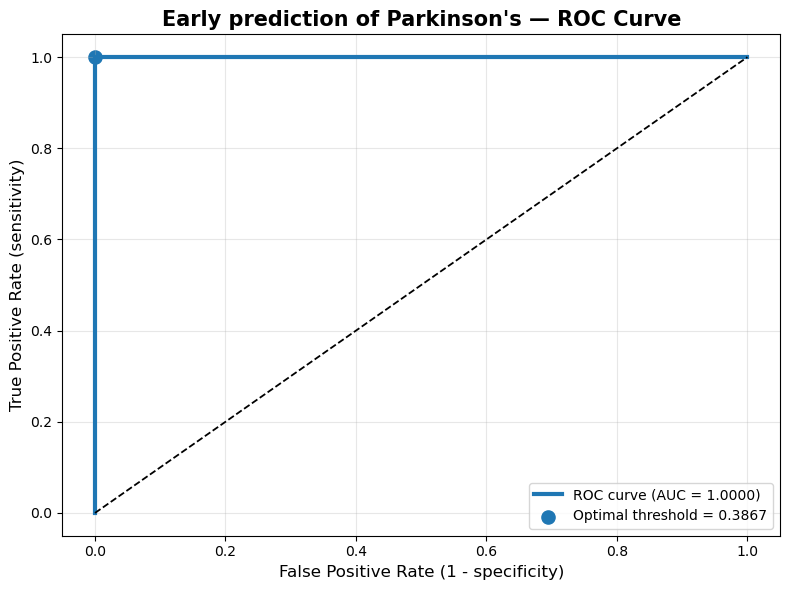

✔ ROC curve saved as: parkinsons_graphs\roc_early_parkinsons.png


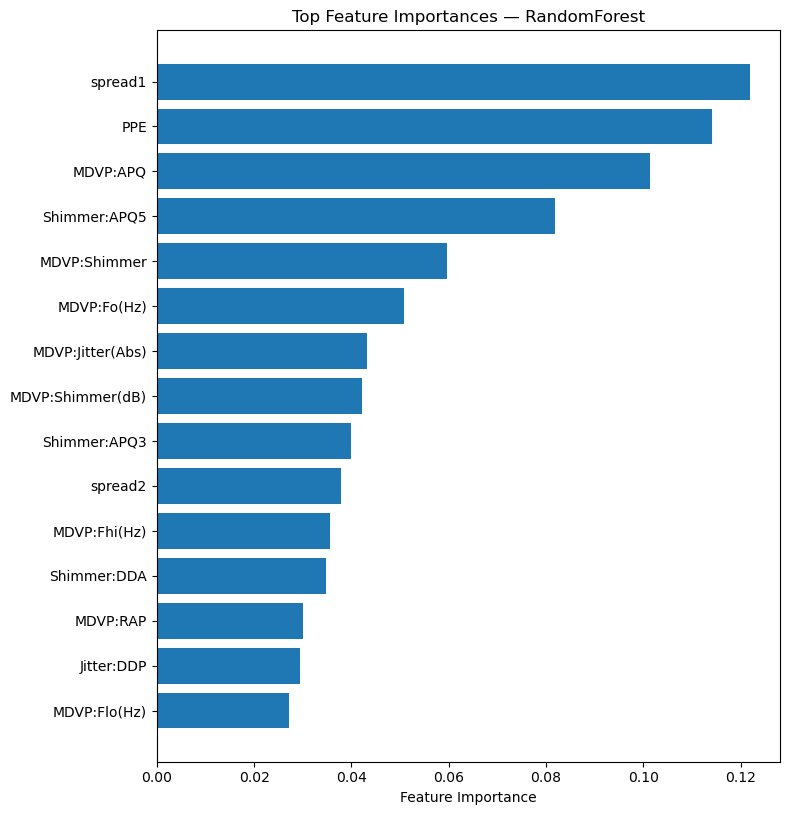

✔ Feature importance graph saved as: parkinsons_graphs\feature_importances_parkinsons.png

=== SUMMARY ===
AUC: 1.0000
Optimal Threshold: 0.3867
Sensitivity: 1.0000
Specificity: 1.0000


In [3]:
# ======== ROC + Feature Importances + Save Images ========

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import os

# Folder to save output graphs
save_dir = "parkinsons_graphs"
os.makedirs(save_dir, exist_ok=True)

# Get probability scores for positive class (status == 1)
if hasattr(pipe, "predict_proba"):
    scores = pipe.predict_proba(X_test)[:, 1]
elif hasattr(pipe, "decision_function"):
    scores = pipe.decision_function(X_test)
else:
    scores = pipe.predict(X_test).astype(float)

# Compute ROC + AUC
fpr, tpr, thresholds = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

# Optimal threshold – Youden's J
youden_j = tpr - fpr
ix = np.argmax(youden_j)
opt_thresh = thresholds[ix]
opt_point = (fpr[ix], tpr[ix])

# ------------------------- PLOT ROC -------------------------
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=3, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.3)
plt.scatter(opt_point[0], opt_point[1], s=90, marker='o',
            label=f"Optimal threshold = {opt_thresh:.4f}")
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=12)
plt.ylabel('True Positive Rate (sensitivity)', fontsize=12)
plt.title("Early prediction of Parkinson's — ROC Curve", fontsize=15, weight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

roc_path = os.path.join(save_dir, "roc_early_parkinsons.png")
plt.savefig(roc_path, dpi=220)
plt.show()

print(f"✔ ROC curve saved as: {roc_path}")

# ---------------------- FEATURE IMPORTANCES ----------------------
try:
    clf = pipe.named_steps['clf']
    if hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
        feat_names = list(X_test.columns)

        idx = np.argsort(importances)[::-1]
        top_n = min(15, len(importances))

        plt.figure(figsize=(8, 0.35 * top_n + 3))
        plt.barh(np.array(feat_names)[idx][:top_n][::-1], importances[idx][:top_n][::-1])
        plt.xlabel("Feature Importance")
        plt.title("Top Feature Importances — RandomForest")
        plt.tight_layout()

        feat_path = os.path.join(save_dir, "feature_importances_parkinsons.png")
        plt.savefig(feat_path, dpi=220)
        plt.show()

        print(f"✔ Feature importance graph saved as: {feat_path}")
    else:
        print("RandomForest does not expose feature_importances_.")
except Exception as e:
    print("Could not extract feature importances:", e)

# ------------------------- SUMMARY -------------------------
print("\n=== SUMMARY ===")
print(f"AUC: {roc_auc:.4f}")
print(f"Optimal Threshold: {opt_thresh:.4f}")
print(f"Sensitivity: {tpr[ix]:.4f}")
print(f"Specificity: {1 - fpr[ix]:.4f}")
